In [1]:
import pandas as pd
import numpy as np
import klib
from platform import python_version

%precision 2
pd.set_option('max_columns',200)
pd.set_option('display.precision',2)
pd.set_option('display.float_format','{:,.4f}'.format)

print('python',python_version())
print(np.__name__, np.__version__)
print(pd.__name__, pd.__version__)
print(klib.__name__, klib.__version__)

python 3.9.2
numpy 1.20.1
pandas 1.1.4
klib 0.1.5


In [2]:
file_parquet = '20210228_chi_crashes.parquet'
file_parquet_c = '20210228_chi_crashes_c.parquet'

# Download source data 

The sequence of notebooks start from the direct raw download of data from the chicago data portal.

We worked with a snapshot downloaded on 2021-02-28, but the whole process is expected to be re-executable without any issues as in later stages we filter down the working data to just include the years of 2018,2019,2020, which are all in the past so we don't expect them to change.

Also, we write the data to parquet format to be able to read and write the huge amount of data faster.

We kept the download code commented out to prevent slowing down the process since we already had local copies.

In [3]:
#df_raw = pd.read_csv('https://data.cityofchicago.org/api/views/85ca-t3if/rows.csv',
#                     low_memory=False, parse_dates=['CRASH_DATE','DATE_POLICE_NOTIFIED'], index_col=0)
#df_raw.info()

In [4]:
#df_raw.to_parquet(file_parquet)

# Read RAW parquet file

Once the raw data is downloaded once to the local parquet file, you can comment the code in the previous section and only start reading from the local data.

In [5]:
df_raw = pd.read_parquet(file_parquet).reset_index(drop=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481623 entries, 0 to 481622
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   RD_NO                          477413 non-null  object        
 1   CRASH_DATE_EST_I               36142 non-null   object        
 2   CRASH_DATE                     481623 non-null  datetime64[ns]
 3   POSTED_SPEED_LIMIT             481623 non-null  int64         
 4   TRAFFIC_CONTROL_DEVICE         481623 non-null  object        
 5   DEVICE_CONDITION               481623 non-null  object        
 6   WEATHER_CONDITION              481623 non-null  object        
 7   LIGHTING_CONDITION             481623 non-null  object        
 8   FIRST_CRASH_TYPE               481623 non-null  object        
 9   TRAFFICWAY_TYPE                481623 non-null  object        
 10  LANE_CNT                       198963 non-null  float64       
 11  

GridSpec(6, 6)

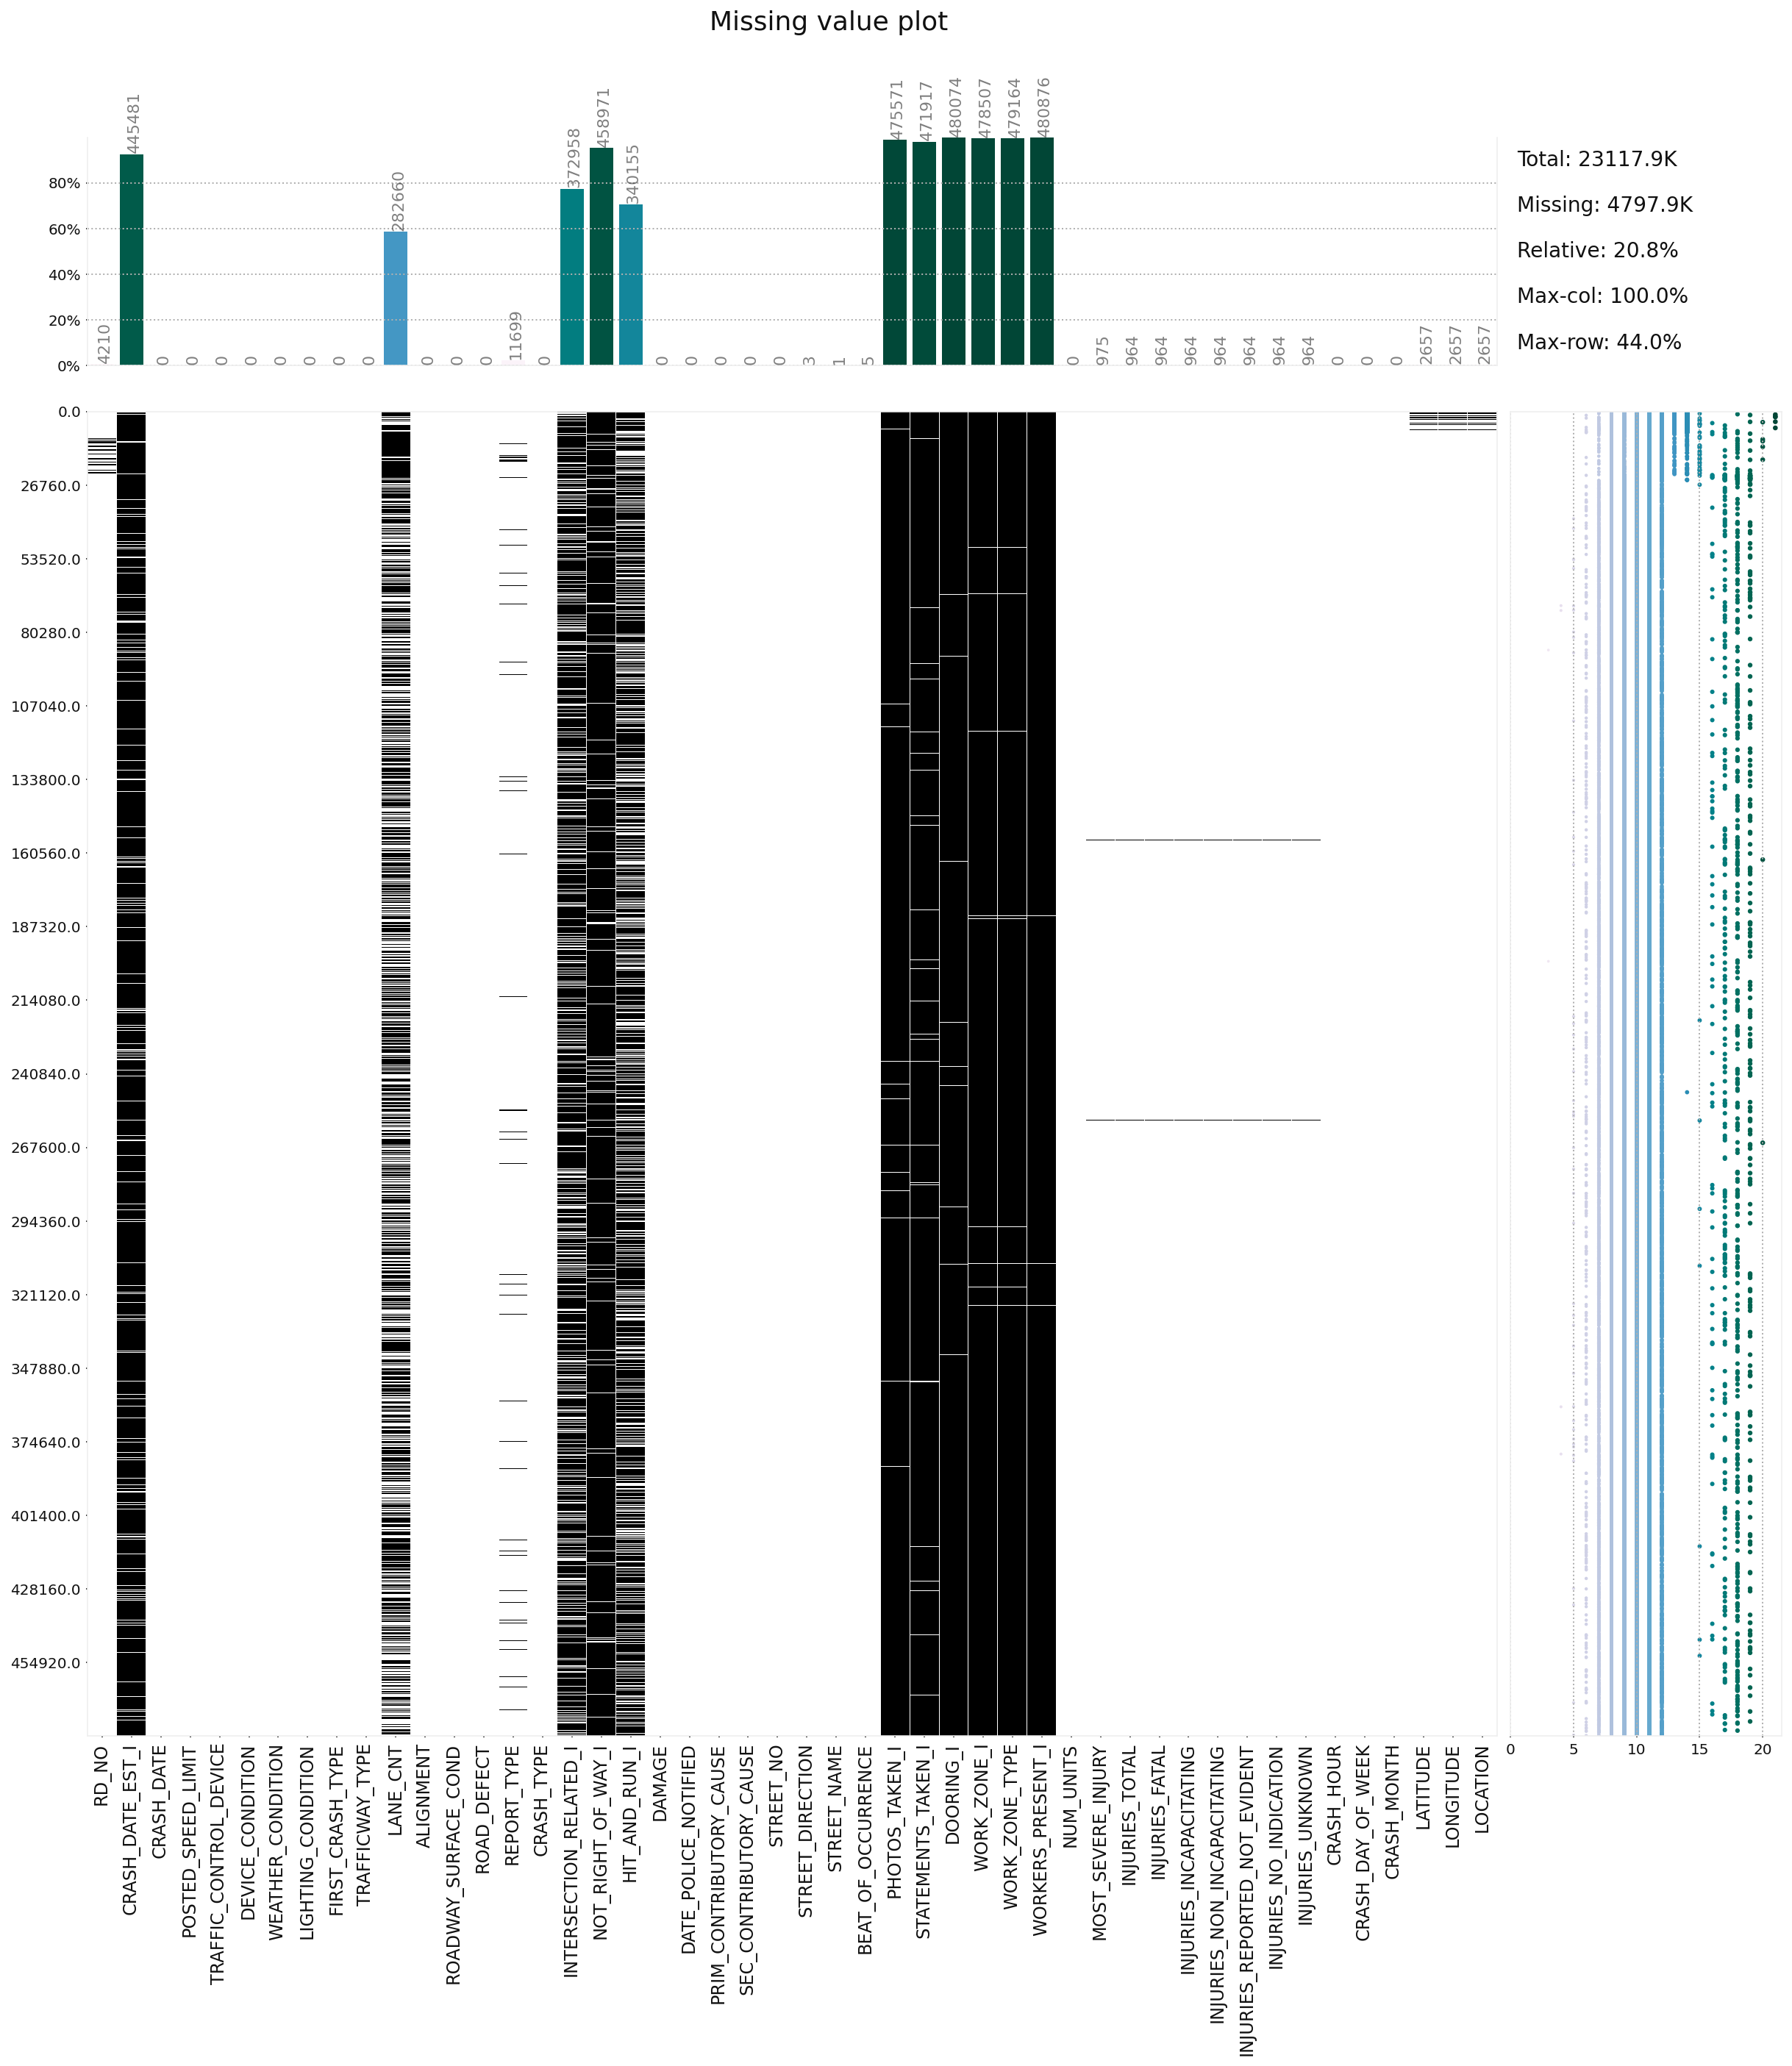

In [6]:
klib.missingval_plot(df_raw)

In [7]:
# Rename long columns
df_1 = df_raw.rename(columns={
    'INJURIES_NON_INCAPACITATING':'INJ_NON_INCAP',               
    'INJURIES_REPORTED_NOT_EVIDENT':'INJ_REPORT_NOT_EVDNT'
})

# Drop unwanted columns
df_1.drop(columns=[
    'RD_NO','CRASH_DATE_EST_I','LANE_CNT','LOCATION','REPORT_TYPE', 'DATE_POLICE_NOTIFIED',
    'PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','DOORING_I','WORK_ZONE_I','WORK_ZONE_TYPE','WORKERS_PRESENT_I',
#    'INTERSECTION_RELATED_I','NOT_RIGHT_OF_WAY_I','HIT_AND_RUN_I', # Don't drop these anymore
], inplace=True)

In [8]:
# Clean and standardize column names
df_c = klib.clean_column_names(df_1)

GridSpec(6, 6)

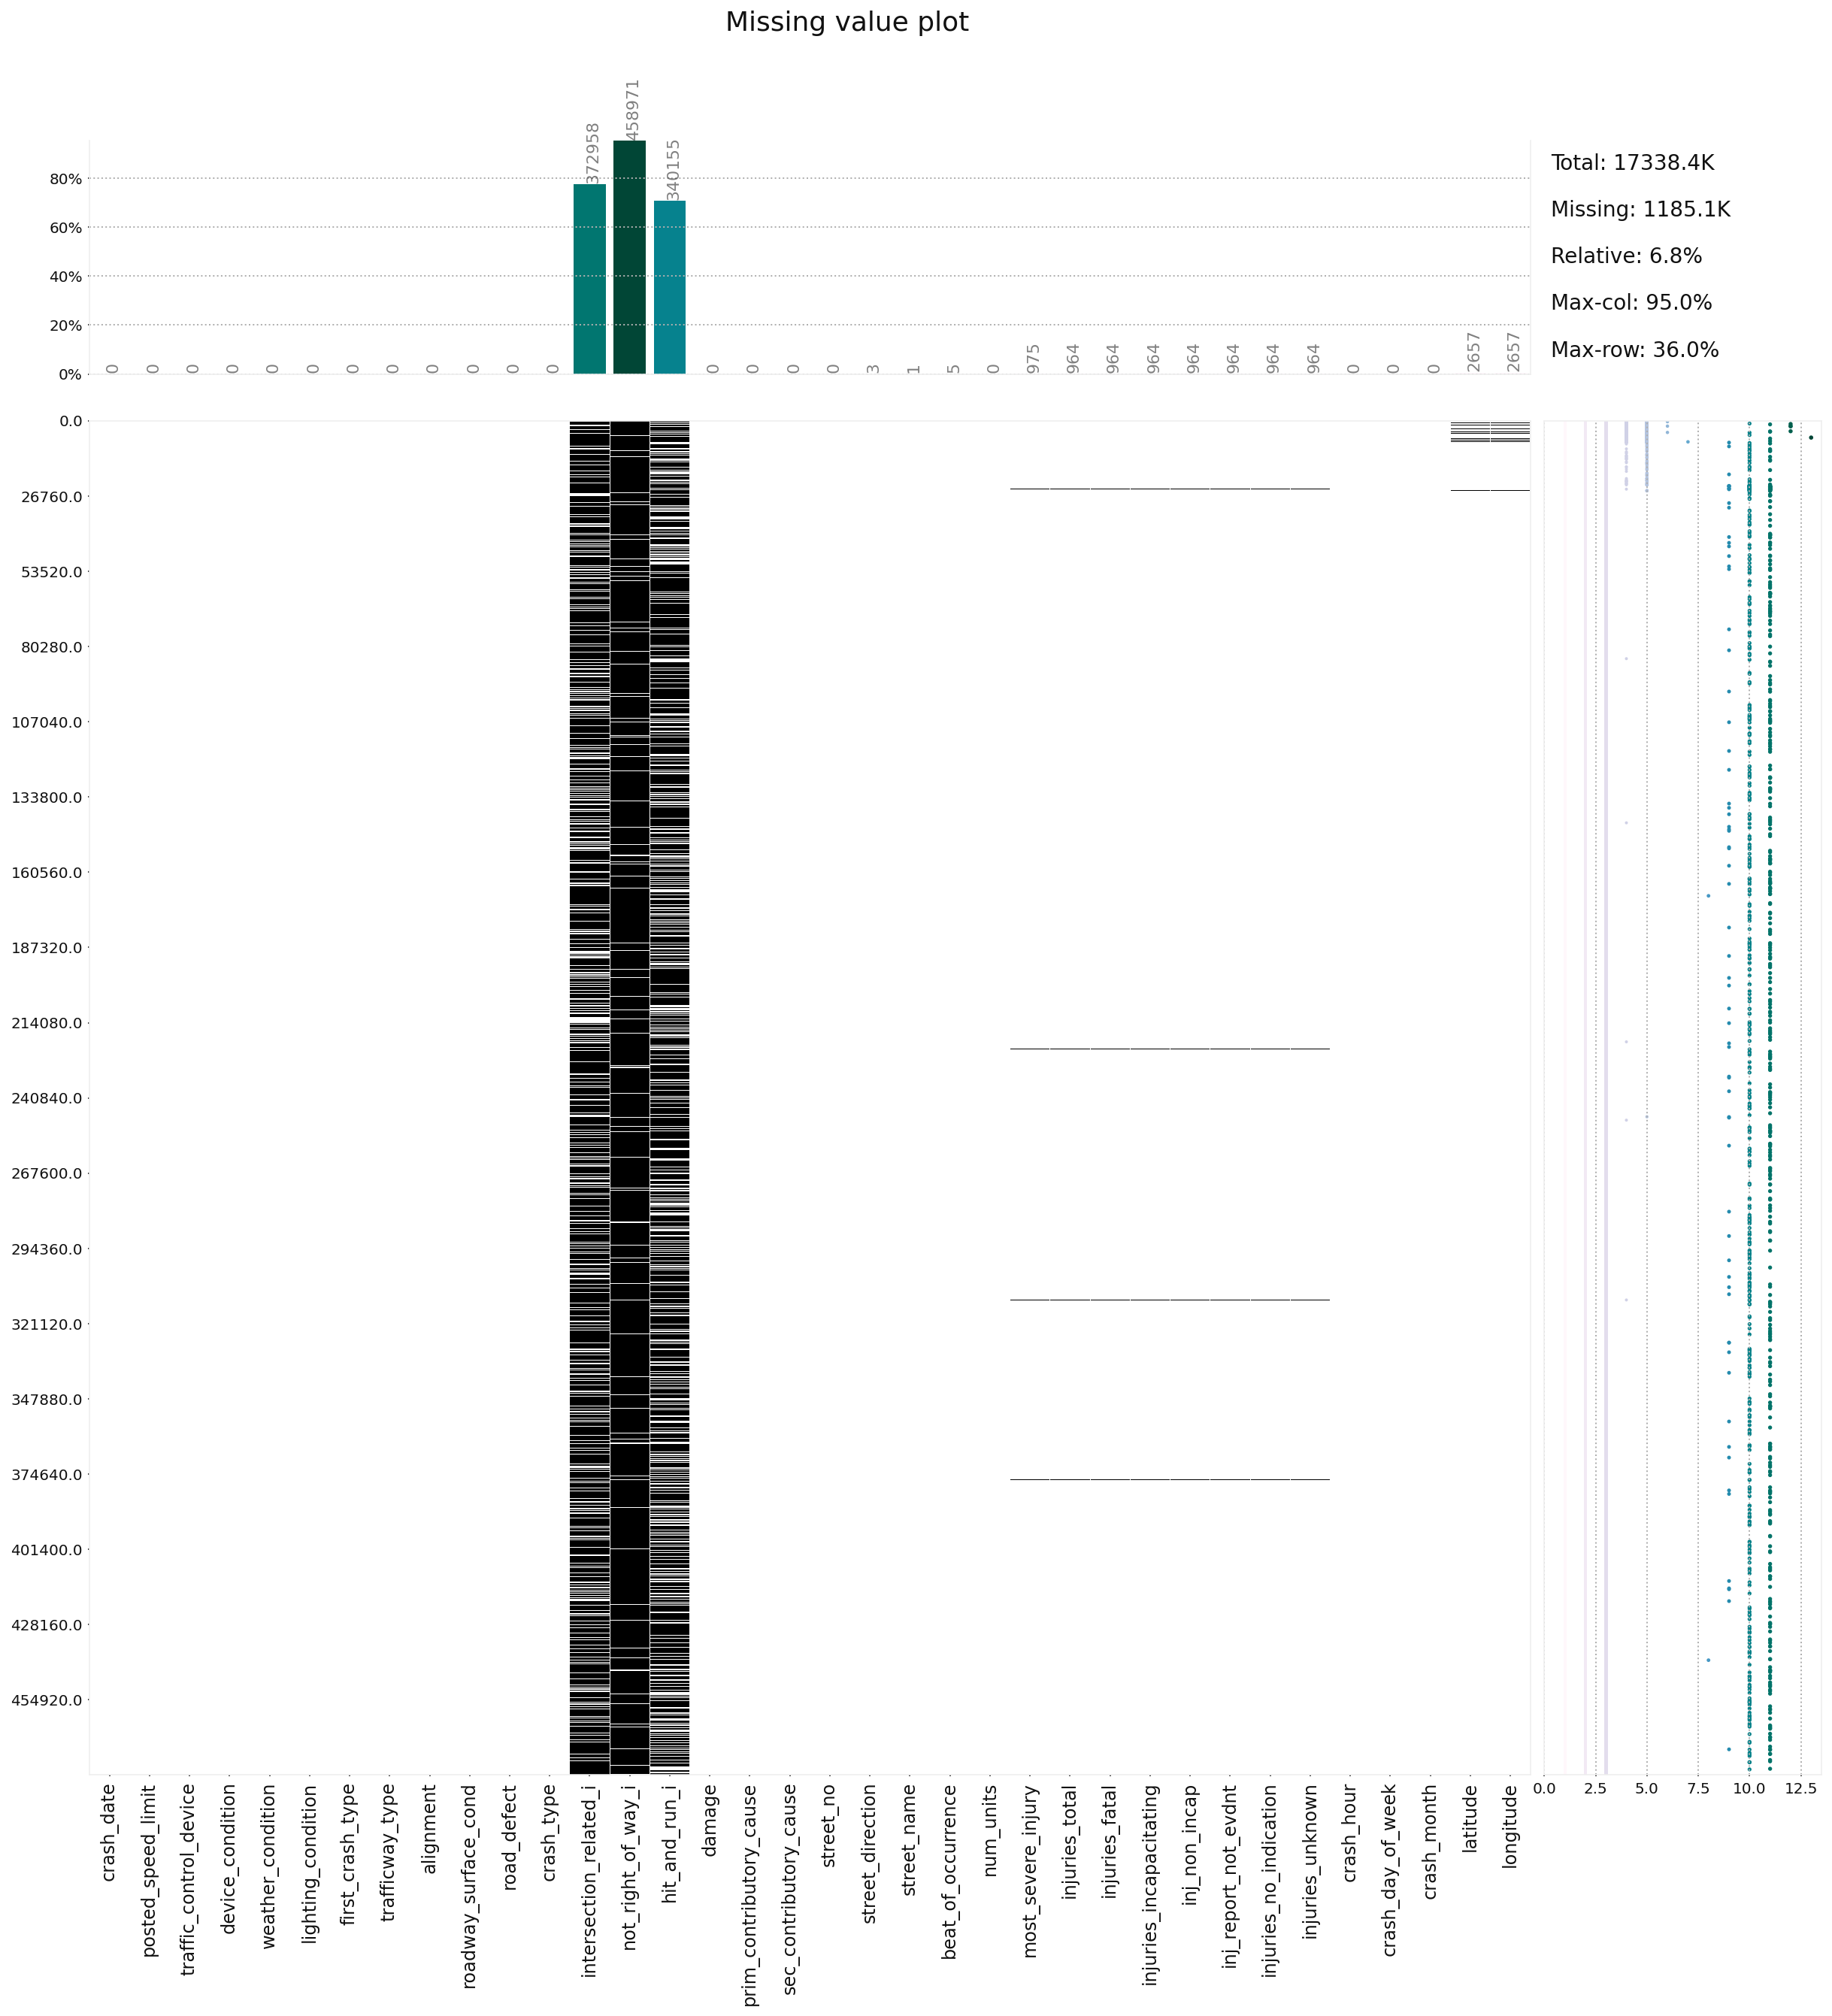

In [9]:
klib.missingval_plot(df_c)

In [10]:
# Fill missing values in these columns with N value, assuming it's the default
df_c.fillna({
    'intersection_related_i':'N',
    'not_right_of_way_i':'N',
    'hit_and_run_i':'N'
}, inplace=True)

GridSpec(6, 6)

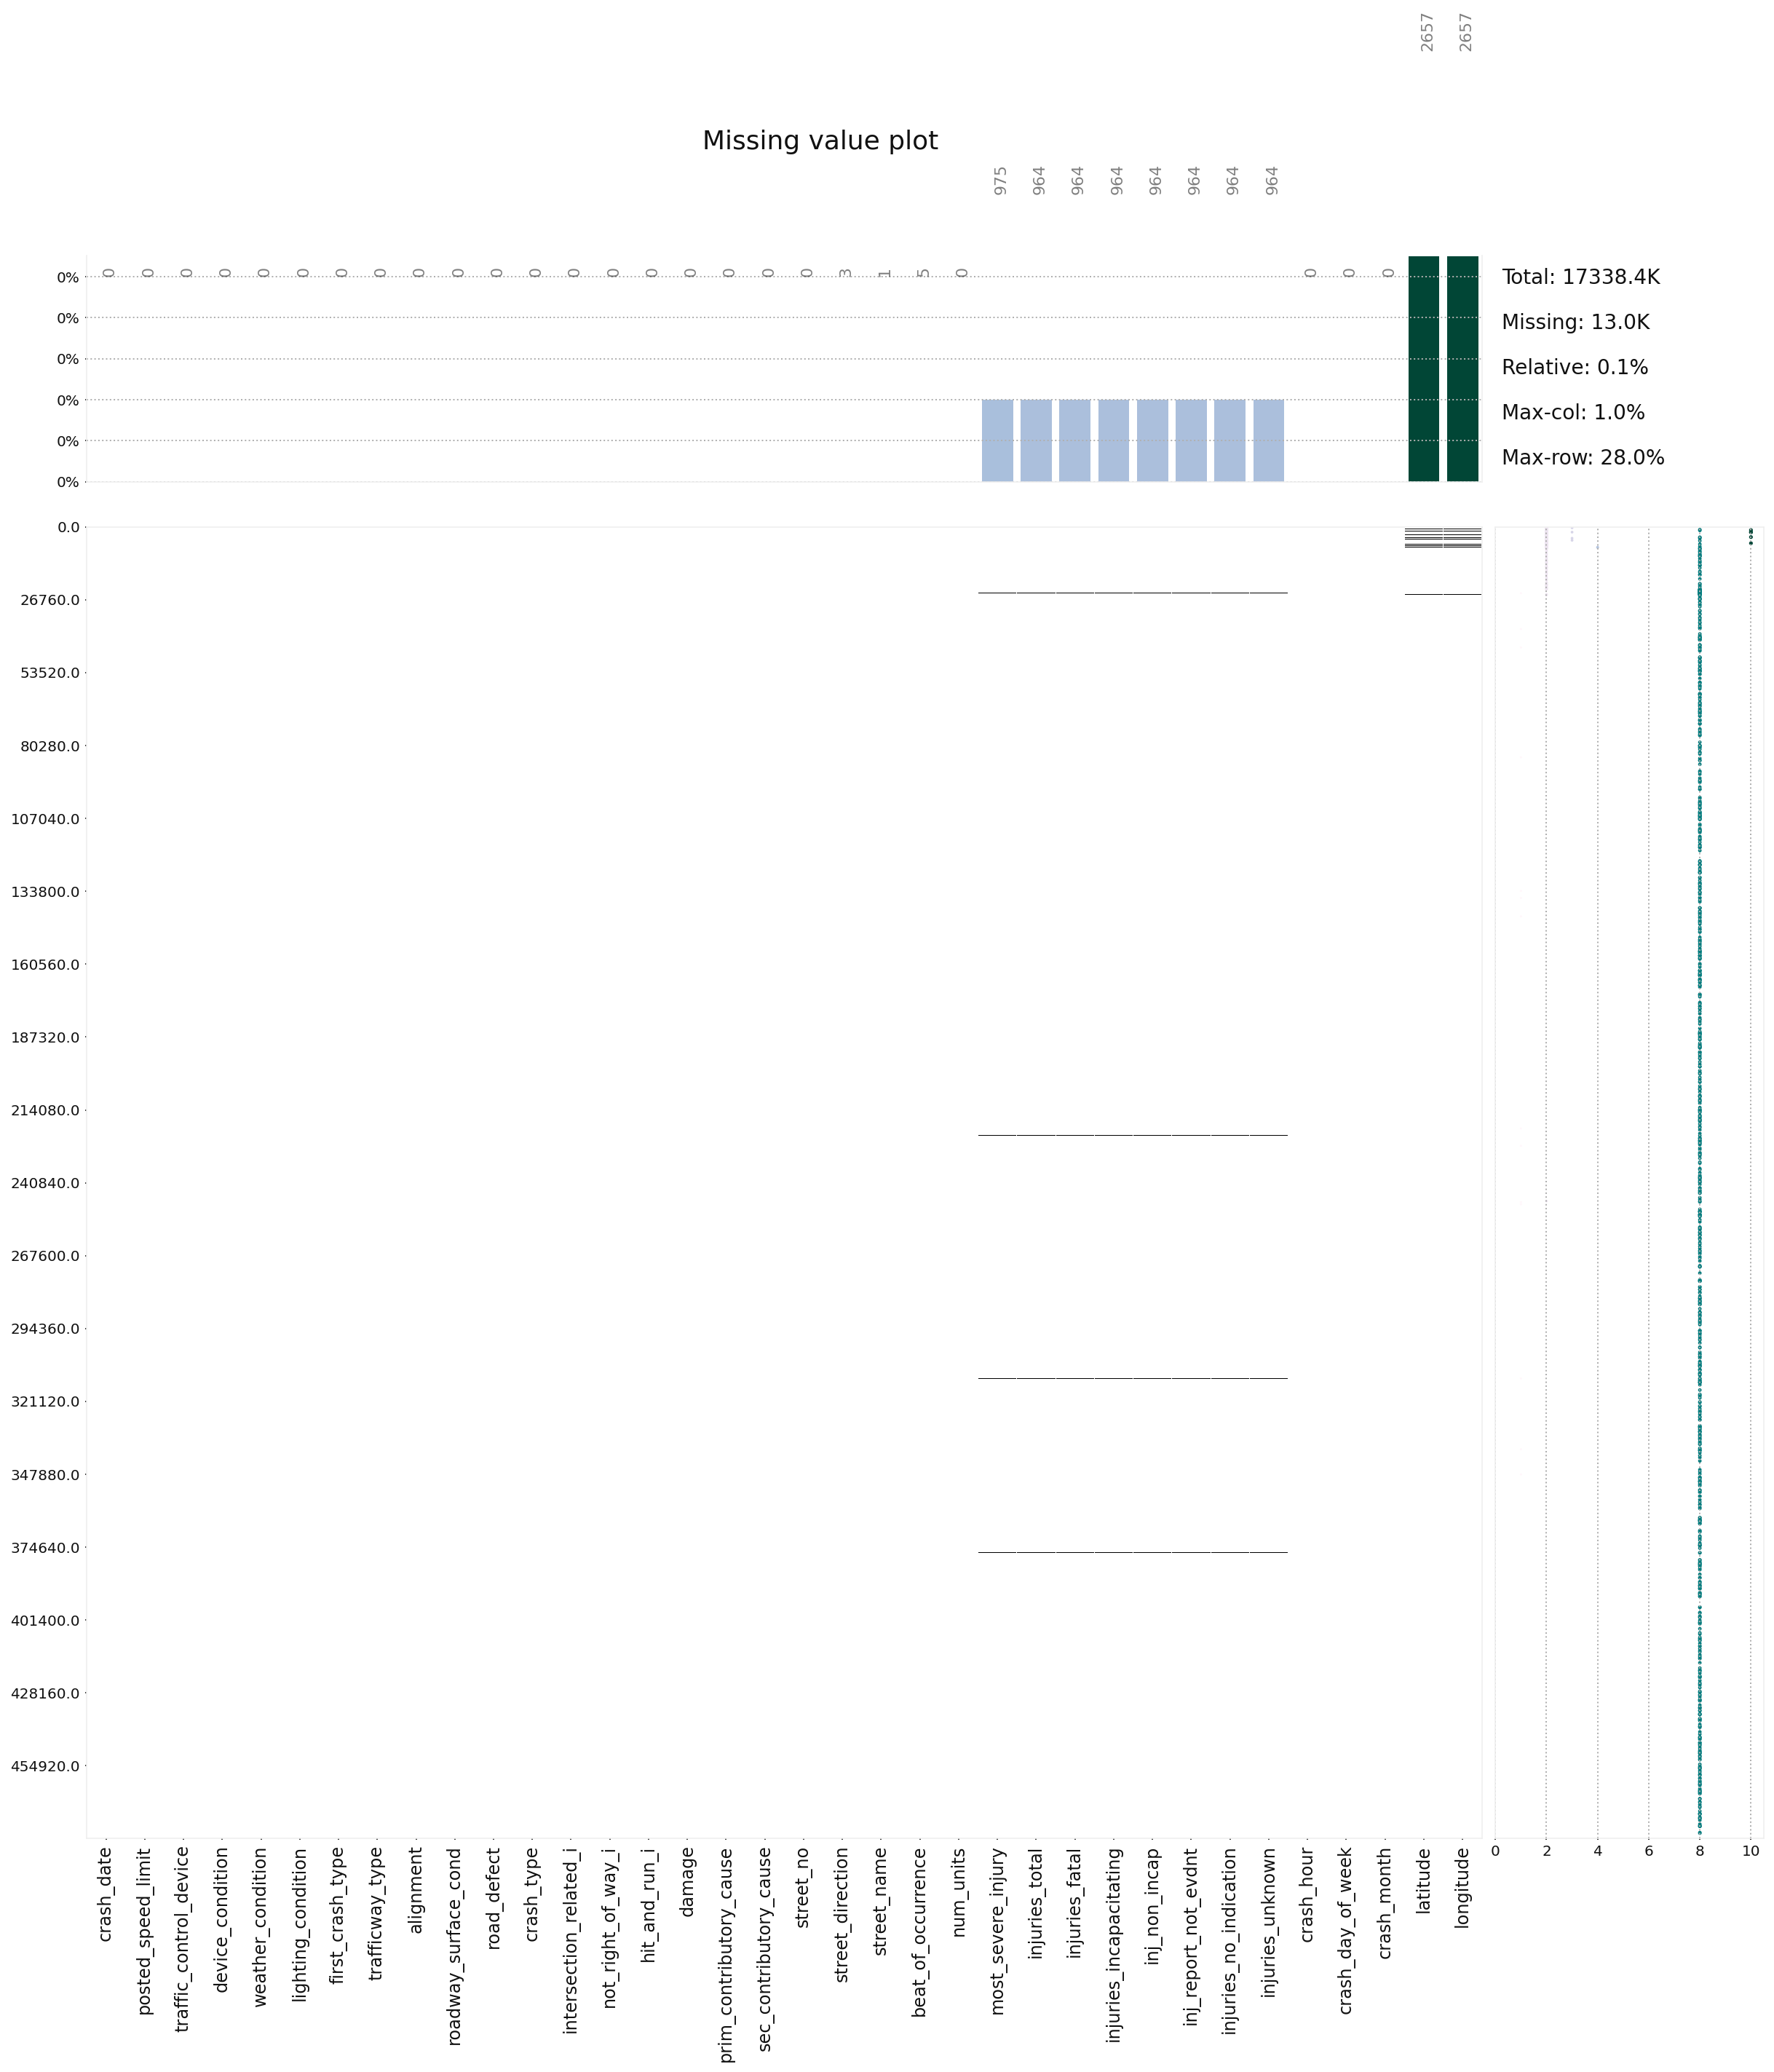

In [11]:
klib.missingval_plot(df_c)

In [12]:
# Set these columns to 0 wherever injuries_total is missing and crash_type is no injury
df_c.loc[((df_c.injuries_total.isna()) & (df_c.crash_type == 'NO INJURY / DRIVE AWAY')),[
          'injuries_total',
          'injuries_fatal',
          'injuries_incapacitating',
          'inj_non_incap',
          'inj_report_not_evdnt',
          'injuries_no_indication',
          'injuries_unknown'
         ]] = 0

In [13]:
# Drop rows where injuries_total is missing
df_c.drop(df_c[df_c.injuries_total.isna()].index, inplace=True)

In [14]:
# Set most_severe_injury = NO INDICATION OF INJURY,
# wherever most_severe_injury is missing and injuries_total is 0
df_c.loc[(df_c.most_severe_injury.isna()) & (df_c.injuries_total == 0),'most_severe_injury'] = 'NO INDICATION OF INJURY'

In [15]:
df_c.most_severe_injury.value_counts(dropna=False)

NO INDICATION OF INJURY     419530
NONINCAPACITATING INJURY     34157
REPORTED, NOT EVIDENT        19265
INCAPACITATING INJURY         7815
FATAL                          470
Name: most_severe_injury, dtype: int64

GridSpec(6, 6)

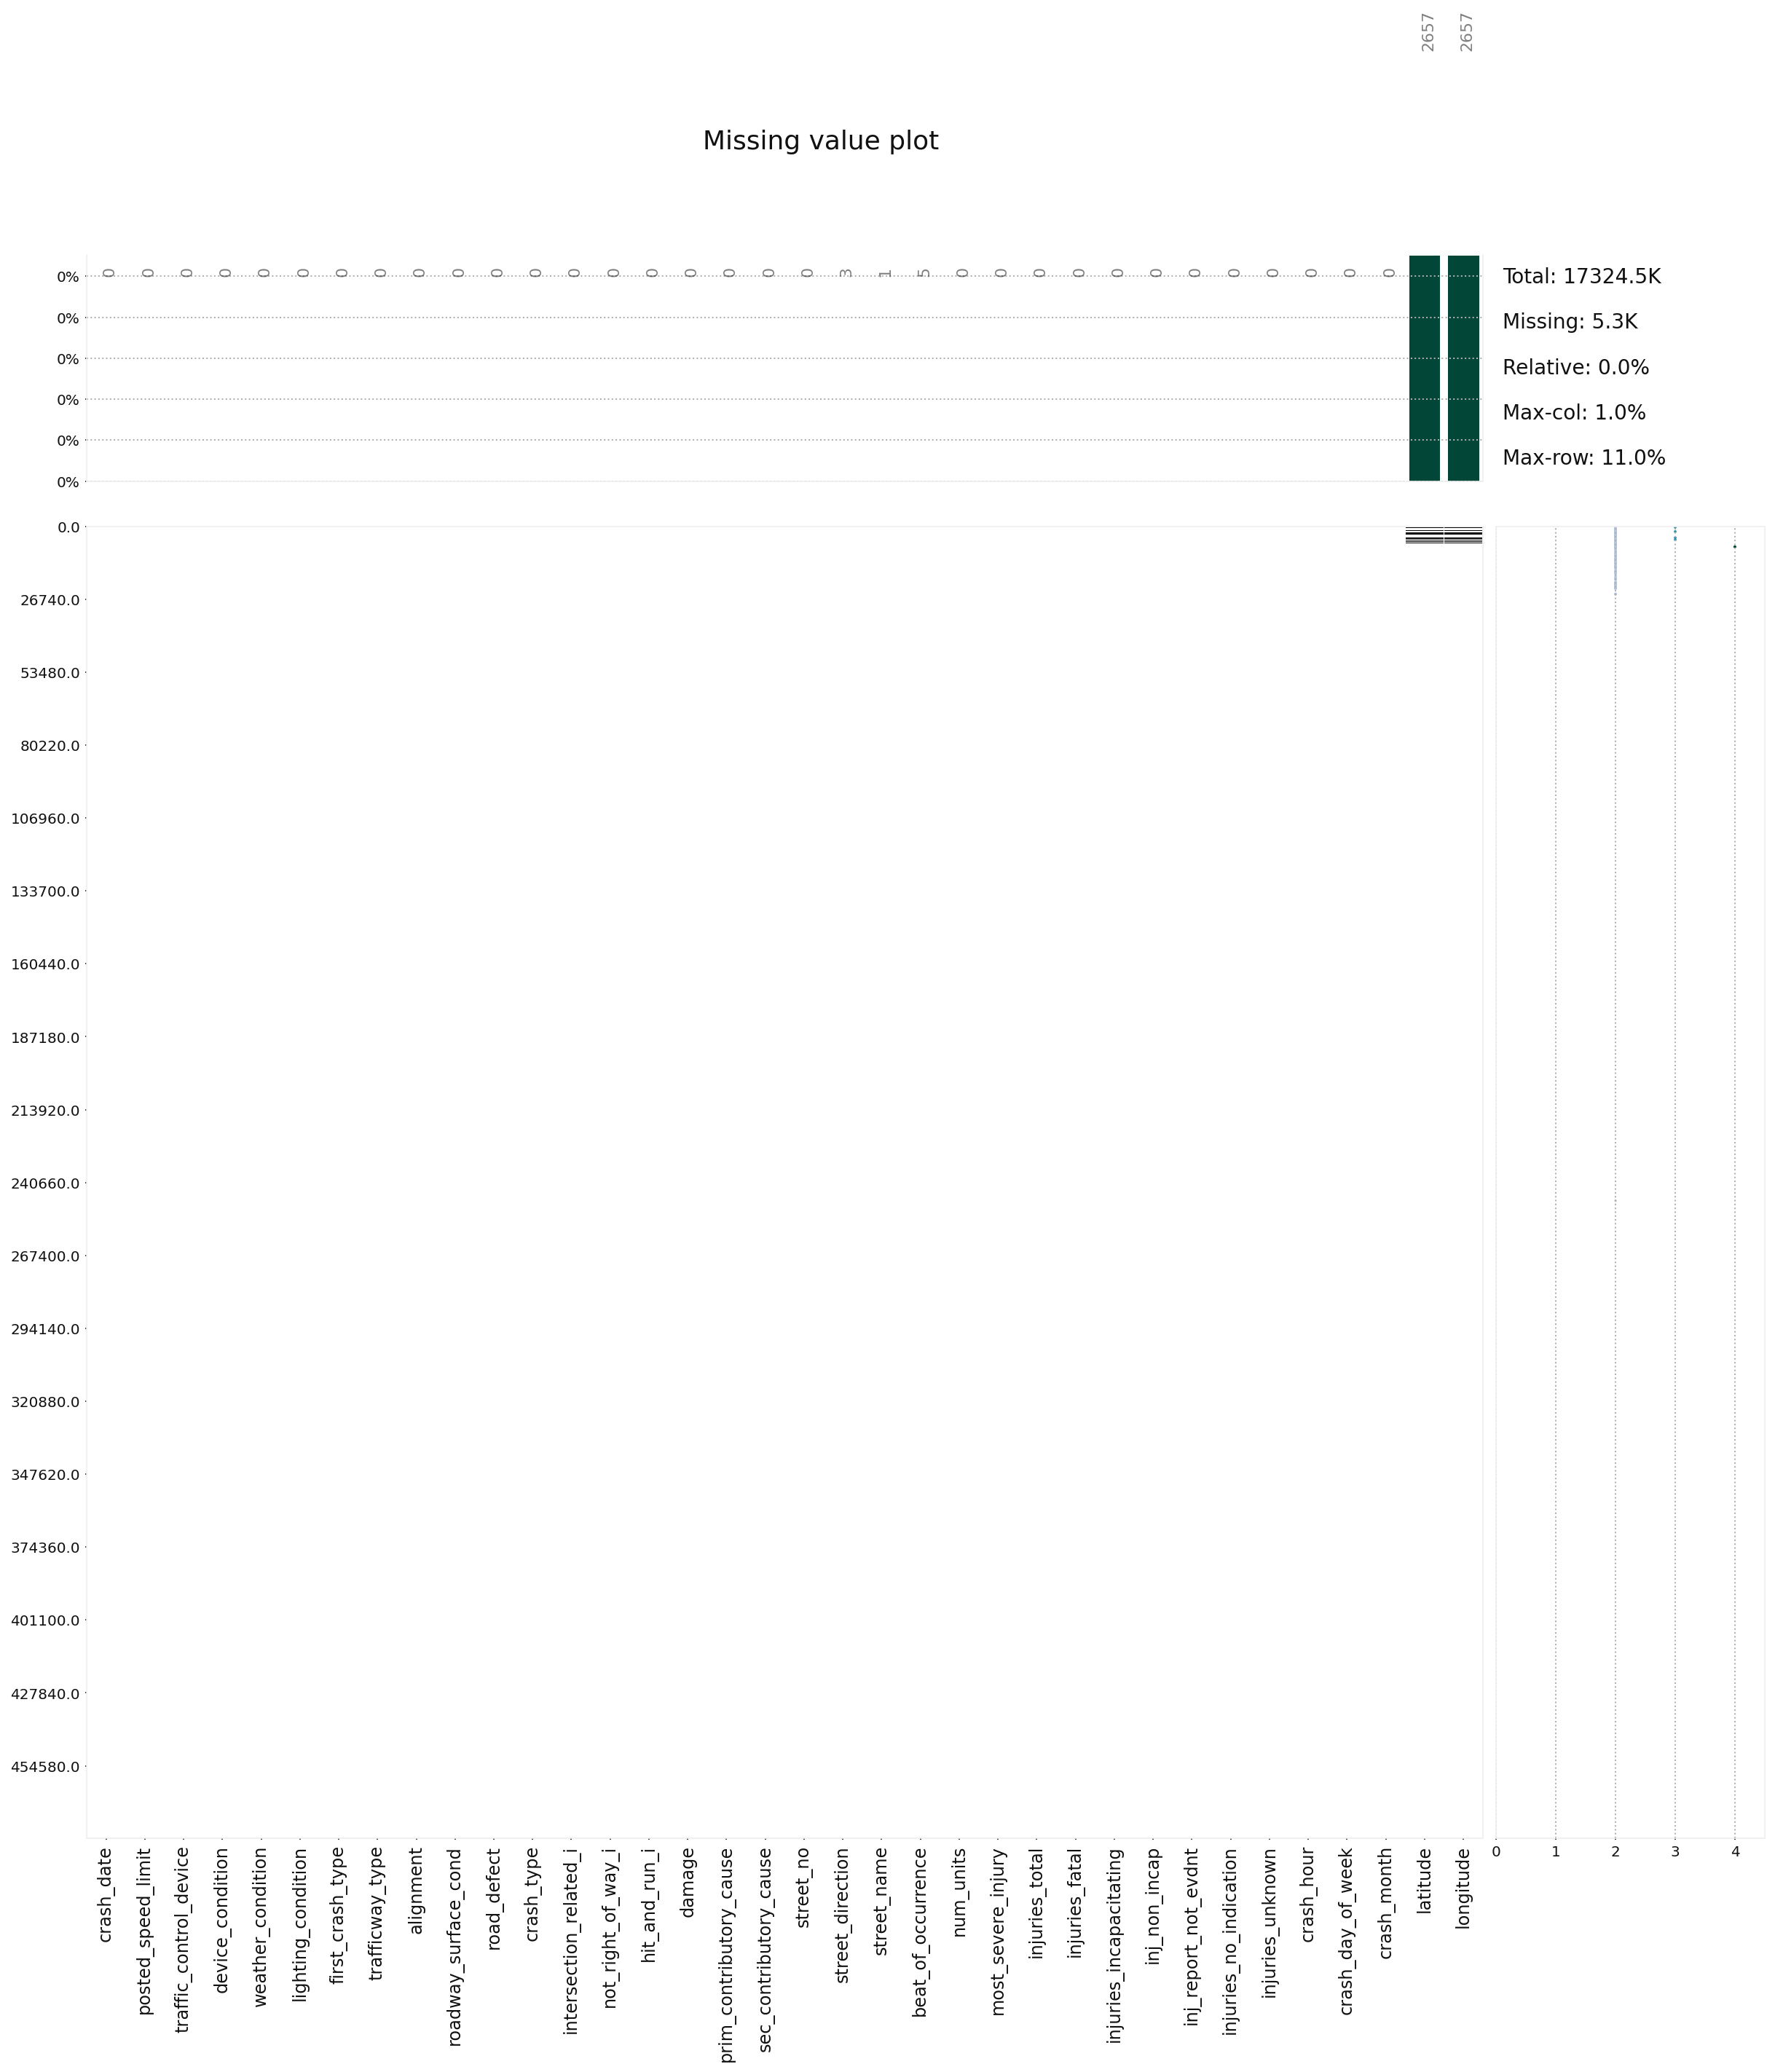

In [16]:
klib.missingval_plot(df_c)

In [17]:
# Fill missing beats

#df_c.loc[240890,'beat_of_occurrence'] = 712
#df_c.loc[304891,'beat_of_occurrence'] = 312
#df_c.loc[340159,'beat_of_occurrence'] = 1711

# Decided to drop records with missing beats. Not worth the step

In [18]:
# create crash year column
df_c['crash_year'] = df_c.crash_date.dt.year

# create address column
#crashes_df2['street_no'] = (crashes_df2['street_no']//100*100).astype(str)
df_c['street_no'] = (df_c['street_no']).astype(str)
df_c['street_direction'] = (df_c['street_direction']).astype(str)
df_c['street_name'] = (df_c['street_name']).astype(str)
df_c['address'] = df_c[['street_no', 'street_direction', 'street_name']].agg(' '.join, axis=1)


In [19]:
df_c2 = klib.data_cleaning(df_c, drop_duplicates=True)

Shape of cleaned data: (481175, 37)Remaining NAs: 5319

Changes:
Dropped rows: 62
     of which 62 duplicates. (Rows: [10397, 10627, 17109, 20852, 21464, 80399, 106076, 114464, 123352, 132118, 156840, 166450, 172470, 174781, 194193, 213271, 223057, 227028, 239791, 248779, 249737, 263539, 288304, 294242, 299648, 314088, 322049, 326238, 360584, 366159, 368169, 376503, 385848, 386308, 387839, 388170, 388562, 389762, 392243, 396348, 398083, 398458, 405571, 408483, 410587, 410658, 415143, 426866, 428806, 434947, 435420, 437252, 440915, 445325, 450767, 457567, 459410, 465108, 468712, 478945, 479992, 480501])
Dropped columns: 1
     of which 1 single valued.     Columns: ['injuries_unknown']
Dropped missing values: 0
Reduced memory by at least: 101.89 MB (-71.16%)



In [20]:
# drop rows that have both long and lat == 0
df_c2 = df_c2.query('latitude != 0 and longitude !=0')

In [21]:
# At this point, Drop any rows that still has NA's
df_c2.dropna(axis=0, inplace=True)

In [22]:
# Fix floats that should be int after we got rid of NA values
df_c2.beat_of_occurrence = df_c2.beat_of_occurrence.astype(int)
df_c2.injuries_total = df_c2.injuries_total.astype(int)
df_c2.injuries_fatal = df_c2.injuries_fatal.astype(int)
df_c2.injuries_incapacitating = df_c2.injuries_incapacitating.astype(int)
df_c2.inj_non_incap = df_c2.inj_non_incap.astype(int)
df_c2.inj_report_not_evdnt = df_c2.inj_report_not_evdnt.astype(int)
df_c2.injuries_no_indication = df_c2.injuries_no_indication.astype(int)


In [23]:
df_c2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478484 entries, 0 to 481622
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_date               478484 non-null  datetime64[ns]
 1   posted_speed_limit       478484 non-null  int8          
 2   traffic_control_device   478484 non-null  category      
 3   device_condition         478484 non-null  category      
 4   weather_condition        478484 non-null  category      
 5   lighting_condition       478484 non-null  category      
 6   first_crash_type         478484 non-null  category      
 7   trafficway_type          478484 non-null  category      
 8   alignment                478484 non-null  category      
 9   roadway_surface_cond     478484 non-null  category      
 10  road_defect              478484 non-null  category      
 11  crash_type               478484 non-null  category      
 12  intersection_rel

In [24]:
klib.missingval_plot(df_c2)

No missing values found in the dataset.


# Write final DF to parquet

In [25]:
df_c2.to_parquet(file_parquet_c)

In [26]:
crash_df = pd.read_parquet(file_parquet_c)

In [27]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478484 entries, 0 to 481622
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_date               478484 non-null  datetime64[ns]
 1   posted_speed_limit       478484 non-null  int8          
 2   traffic_control_device   478484 non-null  category      
 3   device_condition         478484 non-null  category      
 4   weather_condition        478484 non-null  category      
 5   lighting_condition       478484 non-null  category      
 6   first_crash_type         478484 non-null  category      
 7   trafficway_type          478484 non-null  category      
 8   alignment                478484 non-null  category      
 9   roadway_surface_cond     478484 non-null  category      
 10  road_defect              478484 non-null  category      
 11  crash_type               478484 non-null  category      
 12  intersection_rel

# Extra Steps

TODO
* [x] Round posted_speed_limit to nearest 5th unit
* [x] Create columns has_injuries and fatalaties
* [x] Drop date_police_notified (done at the top of the notebook)
* [x] Descretize crash_hour into  bins=[-np.inf,6,12,18,np.inf], labels=['overnight','morning','mid_day','evening']

In [28]:
crash_df.posted_speed_limit = crash_df.posted_speed_limit.apply(lambda x: (x//5*5) + round(x%5/5)*5) # rounding at mid-point to nearest 5
crash_df.posted_speed_limit.value_counts()

30     352827
35      33017
25      29078
20      18489
15      16635
10      10152
0        6793
40       4405
5        3769
45       2751
55        368
50         96
100        66
60         24
65         11
70          3
Name: posted_speed_limit, dtype: int64

In [29]:
crash_df['has_injuries'] = crash_df.injuries_total.apply(lambda x: int(x>0))
crash_df['has_injuries'].value_counts()

0    417137
1     61347
Name: has_injuries, dtype: int64

In [30]:
crash_df['has_fatal'] = crash_df.injuries_fatal.apply(lambda x: int(x>0))
crash_df['has_fatal'].value_counts()

0    478019
1       465
Name: has_fatal, dtype: int64

In [31]:
crash_df['crash_time_of_day'] = pd.cut(crash_df.crash_hour, bins=[-np.inf,6,12,18,np.inf], labels=['overnight','morning','mid_day','evening'])
crash_df['crash_time_of_day'].value_counts()

mid_day      201088
morning      143960
evening       80347
overnight     53089
Name: crash_time_of_day, dtype: int64

# Write custom DF to parquet

This is the data frame that has newly created featured and transformed values

In [32]:
features_names = [
    'crash_date',
    'crash_year',
    'crash_month',
    'crash_day_of_week',
    'crash_hour',
    'crash_time_of_day', # New
    'latitude',
    'longitude',
    'beat_of_occurrence',
    'address',
    'street_no',
    'street_direction',
    'street_name',
    'posted_speed_limit',
    'traffic_control_device',
    'device_condition',
    'weather_condition',
    'lighting_condition',
    'trafficway_type',
    'alignment',
    'roadway_surface_cond',
    'road_defect',
    'first_crash_type',
    'prim_contributory_cause',
    'sec_contributory_cause',
    'num_units',
#    'intersection_related_i',
#    'not_right_of_way_i',
#    'hit_and_run_i',
]

target_names = [
    'has_injuries',  # New
    'has_fatal',  # New
    'crash_type',
    'damage',
    'injuries_total',
    'injuries_fatal',
#    'injuries_incapacitating',
#    'inj_non_incap',
#    'inj_report_not_evdnt',
#    'injuries_no_indication',
#    'most_severe_injury',
]

all_columns = features_names + target_names
all_columns

['crash_date',
 'crash_year',
 'crash_month',
 'crash_day_of_week',
 'crash_hour',
 'crash_time_of_day',
 'latitude',
 'longitude',
 'beat_of_occurrence',
 'address',
 'street_no',
 'street_direction',
 'street_name',
 'posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'trafficway_type',
 'alignment',
 'roadway_surface_cond',
 'road_defect',
 'first_crash_type',
 'prim_contributory_cause',
 'sec_contributory_cause',
 'num_units',
 'has_injuries',
 'has_fatal',
 'crash_type',
 'damage',
 'injuries_total',
 'injuries_fatal']

In [33]:
file_crash_df_parquet = 'crash_df.parquet'

In [34]:
crash_df[all_columns].to_parquet(file_crash_df_parquet)

# Read the clean data and select only the required features

In [35]:
crash_df = pd.read_parquet(file_crash_df_parquet)

In [36]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478484 entries, 0 to 481622
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_date               478484 non-null  datetime64[ns]
 1   crash_year               478484 non-null  int16         
 2   crash_month              478484 non-null  int8          
 3   crash_day_of_week        478484 non-null  int8          
 4   crash_hour               478484 non-null  int8          
 5   crash_time_of_day        478484 non-null  category      
 6   latitude                 478484 non-null  float32       
 7   longitude                478484 non-null  float32       
 8   beat_of_occurrence       478484 non-null  int64         
 9   address                  478484 non-null  string        
 10  street_no                478484 non-null  category      
 11  street_direction         478484 non-null  category      
 12  street_name     

In [37]:
crash_features = crash_df[features_names]
crash_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478484 entries, 0 to 481622
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_date               478484 non-null  datetime64[ns]
 1   crash_year               478484 non-null  int16         
 2   crash_month              478484 non-null  int8          
 3   crash_day_of_week        478484 non-null  int8          
 4   crash_hour               478484 non-null  int8          
 5   crash_time_of_day        478484 non-null  category      
 6   latitude                 478484 non-null  float32       
 7   longitude                478484 non-null  float32       
 8   beat_of_occurrence       478484 non-null  int64         
 9   address                  478484 non-null  string        
 10  street_no                478484 non-null  category      
 11  street_direction         478484 non-null  category      
 12  street_name     

In [38]:
crash_targets = crash_df[target_names]
crash_targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478484 entries, 0 to 481622
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   has_injuries    478484 non-null  int64   
 1   has_fatal       478484 non-null  int64   
 2   crash_type      478484 non-null  category
 3   damage          478484 non-null  category
 4   injuries_total  478484 non-null  int64   
 5   injuries_fatal  478484 non-null  int64   
dtypes: category(2), int64(4)
memory usage: 19.2 MB
